In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.optimize as opt

In [10]:
q = [np.array([0.1, 0.35])]

ub = 0.3

In [11]:
# error = ((1 - q) * y + q * (1 - y)) * 0.5
#       = (1 * y - q * y + q * 1 - q * y) * 0.5
#       = (q * 1 + 1 * y - 2 q * y) * 0.5 
#       = (sum(1) + (1 - 2q) * y) * 0.5
#       = (sum(q) + (1 - 2q) * y) * 0.5
#        (where * is a dot product)
# Let 2-dimensional y = [a b]
# (solve for b, as the second dimension)
# 2 * error = sum(q) + (1 - 2 q[0]) * a + (1 - 2 q[1]) * b
# 2 * error - (1 - 2 q[1]) * b = sum(q) + (1 - 2 q[0]) * a
# - (1 - 2 q[1]) * b = sum(q) + (1 - 2q[0]) * a - 2 * error
# b = -(sum(q) + (1 - 2 q[0]) * a - 2 * error) / (1 - 2 q[1])

# also solve for 1
# a = -(sum(q) + (1 - 2 q[1]) * b - 2 * error) / (1 - 2 q[0])

p = np.array([0.8, 0.2])

def get_best_y(p, q_list, ub):
    max_iter = 1000
    
    # objective = (1 - y) * p + y * (1 - p)
    # = sum(p) - 2 * y.dot(p) + sum(y)
    # = (1 - 2 * p).dot(y)
    
    # constraint: (1 - y) * q + y * (1 - q) <= 2*ub
    # = sum(q) - 2 * q.dot(y) + 1.dot(y) <= 2*ub
    # = (1 - 2 * q).dot(y) <= 2* ub - sum(q)
    
    def callback(xk, **kwargs):
        print("Iter: %d. Current solution: " % kwargs['nit'], xk)

    
    c = (2 * p - 1)
    a_ub = np.zeros((len(q_list), c.size))
    b_ub = np.zeros(len(q_list))
    for i, q in enumerate(q_list):
        a_ub[i, :] = (1 - 2 * q).reshape((1, 2))
        b_ub[i] = 2 * ub - np.sum(q)
    
    res = opt.linprog(c, A_ub=a_ub, b_ub=b_ub, bounds=(0, 1))
    
    return res.x
    
get_best_y(p, q, ub)


array([0. , 0.5])

In [12]:
def plot_feasible(q_list, ub):
    # compute the horizontal range

    res = 1000
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
              'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
              'tab:olive', 'tab:cyan']
    
    for i, q in enumerate(q_list):

        corner = np.round(q)

        max_b = - (sum(q) + (1 - 2 * q[0]) * corner[0] - 2 * ub) / (1 - 2 * q[1])
        max_a = - (sum(q) + (1 - 2 * q[1]) * corner[1] - 2 * ub) / (1 - 2 * q[0])

        # compute the boundary line for the upper bound
        a = [corner[0], max_a]
        b = [max_b, corner[1]]


        # plot feasible region

        plt.fill_between(np.linspace(corner[0], max_a, res), 
                         np.linspace(corner[1], corner[1], res), 
                         np.linspace(max_b, corner[1], res), 
                         where=np.logical_and(np.linspace(corner[0], max_a, res) <= 1.0, np.linspace(corner[0], max_a, res) >= 0.0),
                         color=colors[i + 2], alpha=0.2, 
                         label=r'Region constrained by $q_%d$' % (i + 1))

def plot_current(q_list, p, ub):
    mpl.style.use('default')

    # compute objective

    res = 40
    values = np.linspace(0, 1, res)
    grid = np.zeros((res, res))
    for i in range(res):
        for j in range(res):
            current_p = np.array([values[j], values[i]])
            y = get_best_y(current_p, q_list, ub)
            grid[i,j] = 0.5 * ((1 - current_p).dot(y) + current_p.dot(1 - y)) 

    # plot objective

    X, Y = np.meshgrid(values, values)
    CS = plt.contour(X, Y, grid, levels=np.linspace(np.min(grid), np.max(grid), 20))
    plt.clabel(CS, inline=1, fontsize=10)


    # plot q, p, and y

    res = 100
    plot_feasible(q_list, ub)
    
    plt.plot(p[0], p[1], 's', label='p = (%.2f, %.2f)' % tuple(p), markersize=12)
    
    worst_y = get_best_y(p, q_list, ub)
    plt.plot(worst_y[0], worst_y[1], 'v', label=r'$\haty$'+' = (%.2f, %.2f)' % tuple(worst_y),
            markersize=12)
    
    for i, q in enumerate(q_list):
        plt.plot(q[0], q[1], 'o', label='$q_%d$ = (%.2f, %.2f)' % (i + 1, q[0], q[1]),
                markersize=12)
    
    plt.axis([-0.05, 1.05, -0.05, 1.05])
    plt.xlabel(r'$y_1$ probability')
    plt.ylabel(r'$y_2$ probability')
    plt.legend(loc='best', framealpha=1)
    
    min_inds = np.unravel_index(grid.argmin(), grid.shape)
    return np.array((values[min_inds[1]], values[min_inds[0]])), y


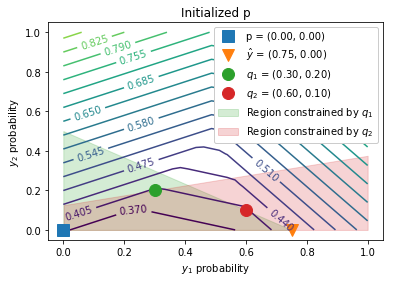

In [13]:
q = [np.array([0.3, 0.2]), np.array([0.6, 0.1])]
ub = 0.4

p = np.array([0, 0])
plt.title('Initialized p')
min_p, worst_y = plot_current(q, p, ub)
plt.savefig('initialized.pdf')


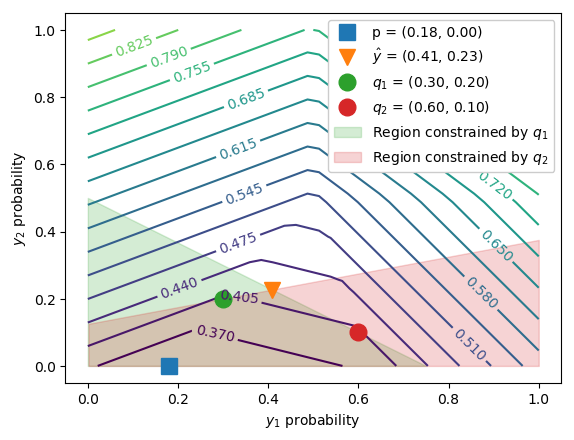

In [14]:
p = min_p
# plt.title('Optimal p')
plot_current(q, p, ub)
plt.savefig('optimal.pdf')



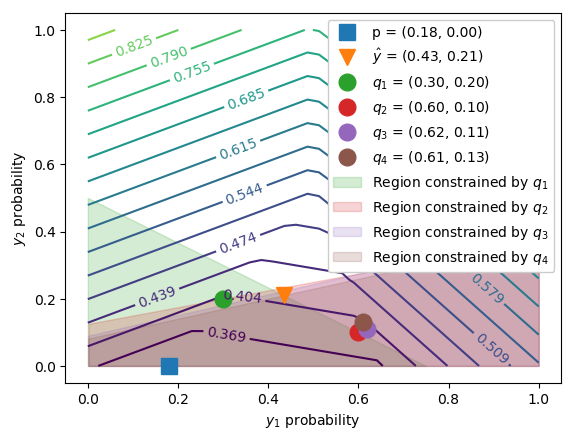

In [15]:
p = min_p
q2 = q.copy()
q2.append(np.array([0.62, 0.11]))
q2.append(np.array([0.61, 0.13]))


# plt.title('Optimal p')
plot_current(q2, p, ub)
plt.savefig('optimal_with_extra_weak_signal.pdf')


